In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
%config InlineBackend.figure_format = 'retina'
from DS_detector import rematch_cat

In [2]:
df = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_rot28_thr0.1_step8.csv')
#df = rematch_cat('/home/rt2122/Data/SRGz/brcat.csv') 

In [3]:
df = df[df['status'] != 'fp']
df = df[df['catalog'] != 'planck_no_z']
df.index = np.arange(len(df))

In [4]:
q_z = [df['z'].quantile(i/6) for i in range(0, 7)]
q_z[0] = 0
q_z[-1] = 2
q_m = [df['M500'].quantile(i/10) for i in range(0, 11)]
q_m[0] = 0
q_m[-1] = 20
print(repr(q_z))
print(repr(q_m))

[0, 0.146, 0.2769047021865845, 0.40646685, 0.545, 0.7208155989646913, 2]
[0, 1.2695500000000002, 1.6839206865134309, 1.9232440762110696, 2.132499258792534, 2.3466809369916932, 2.6002164468177784, 2.9331868815075426, 3.539768803926924, 4.8108245, 20]


In [5]:
q_m500 = {}
for i in range(len(q_z) - 1):
    st = q_z[i]
    en = q_z[i + 1]
    matched = np.logical_and(st <= df['z'], df['z'] < en)
    cur_df = df[matched]
    q_m500[en] = [cur_df['M500'].quantile(i / 10) for i in range(11)]
    q_m500[en][-1] = 20


In [6]:
q_m500 = pd.DataFrame(q_m500)
q_m500

,0.146000,0.276905,0.406467,0.545000,0.720816,2.000000
0,0.009600,0.309300,0.324500,0.472700,0.958000,1.282935
1,0.329700,1.041454,1.507556,1.663179,1.737631,1.715519
2,0.613820,1.520560,1.796266,1.904794,1.949375,1.881850
3,0.929140,1.829720,2.049589,2.101887,2.096046,2.037198
4,1.272120,2.168034,2.288912,2.293961,2.278848,2.155825
5,1.632600,2.603800,2.526098,2.488122,2.428041,2.297122
6,1.903060,3.170817,2.877972,2.682044,2.655300,2.440612
7,2.268199,3.775995,3.606200,2.953453,2.891080,2.690182
8,2.736071,4.357869,4.906258,3.500986,3.318380,2.973040
9,3.591454,5.313178,5.912650,4.956790,4.112285,3.522752


In [7]:
recalls = []
for j in range(len(q_m500[q_z[1]]) - 1):
    line = {}
    for i in range(len(q_z) - 1):
        z_st = q_z[i]
        z_en = q_z[i + 1]
        m_st = q_m500[z_en][j]
        m_en = q_m500[z_en][j + 1]
        
        matched1 = np.logical_and(z_st <= df['z'], df['z'] < z_en)
        matched2 = np.logical_and(m_st <= df['M500'], df['M500'] < m_en)
        cur_df = df[np.logical_and(matched1, matched2)]
        recall = np.count_nonzero(cur_df['status'] == 'tp') / len(cur_df)
        line['({:.2f},{:.2f})'.format(z_st, z_en)] = recall
    recalls.append(pd.DataFrame(line, index=[j]))
recalls = pd.concat(recalls)

In [8]:
recalls

,"(0.00,0.15)","(0.15,0.28)","(0.28,0.41)","(0.41,0.55)","(0.55,0.72)","(0.72,2.00)"
0,0.029412,0.038835,0.048544,0.049020,0.038835,0.039216
1,0.019417,0.147059,0.137255,0.088235,0.029412,0.029126
2,0.088235,0.205882,0.088235,0.049505,0.049020,0.019608
3,0.254902,0.176471,0.107843,0.106796,0.058252,0.049020
4,0.411765,0.267327,0.178218,0.107843,0.049020,0.039216
5,0.558824,0.384615,0.221154,0.156863,0.049020,0.039216
6,0.627451,0.745098,0.401961,0.215686,0.089109,0.087379
7,0.754902,0.862745,0.715686,0.274510,0.086538,0.088235
8,0.813725,0.862745,0.970588,0.529412,0.215686,0.127451
9,0.873786,0.980583,0.961165,0.932039,0.737864,0.359223


In [9]:
cm = sns.light_palette("green", as_cmap=True)

s = recalls.style.background_gradient(cmap=cm)
s

,"(0.00,0.15)","(0.15,0.28)","(0.28,0.41)","(0.41,0.55)","(0.55,0.72)","(0.72,2.00)"
0,0.029412,0.038835,0.048544,0.049020,0.038835,0.039216
1,0.019417,0.147059,0.137255,0.088235,0.029412,0.029126
2,0.088235,0.205882,0.088235,0.049505,0.049020,0.019608
3,0.254902,0.176471,0.107843,0.106796,0.058252,0.049020
4,0.411765,0.267327,0.178218,0.107843,0.049020,0.039216
5,0.558824,0.384615,0.221154,0.156863,0.049020,0.039216
6,0.627451,0.745098,0.401961,0.215686,0.089109,0.087379
7,0.754902,0.862745,0.715686,0.274510,0.086538,0.088235
8,0.813725,0.862745,0.970588,0.529412,0.215686,0.127451
9,0.873786,0.980583,0.961165,0.932039,0.737864,0.359223


In [10]:
z_st = 0.1
z_en=0.2
'({:.2f},{:.2f})'.format(z_st, z_en)

'(0.10,0.20)'

In [11]:
recalls = []
for j in range(len(q_m) - 1):
    line = {}
    m_st = q_m[j]
    m_en = q_m[j + 1]
    for i in range(len(q_z) - 1):
        z_st = q_z[i]
        z_en = q_z[i + 1]
        
        matched1 = np.logical_and(z_st <= df['z'], df['z'] < z_en)
        matched2 = np.logical_and(m_st <= df['M500'], df['M500'] < m_en)
        cur_df = df[np.logical_and(matched1, matched2)]
        recall = np.count_nonzero(cur_df['status'] == 'tp') / len(cur_df)
        line['({:.2f},{:.2f})'.format(z_st, z_en)] = recall
    recalls.append(pd.DataFrame(line, index=['({:.2f},{:.2f})'.format(m_st, m_en)]))
recalls = pd.concat(recalls)

ZeroDivisionError: division by zero

In [15]:
cm = sns.light_palette("green", as_cmap=True)

s = recalls.style.background_gradient(cmap=cm)
s

,"(0.00,0.15)","(0.15,0.28)","(0.28,0.41)","(0.41,0.55)","(0.55,0.72)","(0.72,2.00)"
"(0.00,1.59)",0.152000,0.099099,0.052632,0.068493,0.022222,0.081633
"(1.59,2.00)",0.554745,0.194030,0.119205,0.062147,0.035714,0.017621
"(2.00,2.35)",0.673913,0.178218,0.143791,0.079365,0.059908,0.044444
"(2.35,2.81)",0.728155,0.298969,0.184049,0.156250,0.062500,0.066038
"(2.81,20.00)",0.863158,0.816631,0.744681,0.533520,0.318713,0.211321


In [29]:
nums = []
for j in range(len(q_m500) - 1):
    line = {}
    for i in range(len(q_z) - 1):
        z_st = q_z[i]
        z_en = q_z[i + 1]
        m_st = q_m500[z_en][j]
        m_en = q_m500[z_en][j + 1]
        
        matched1 = np.logical_and(z_st <= df['z'], df['z'] < z_en)
        matched2 = np.logical_and(m_st <= df['M500'], df['M500'] < m_en)
        cur_df = df[np.logical_and(matched1, matched2)]
        num = len(cur_df)
        line['({:.2f},{:.2f})'.format(z_st, z_en)] = num
    nums.append(pd.DataFrame(line, index=[j]))
nums = pd.concat(nums)

In [30]:
nums

,"(0.00,0.15)","(0.15,0.28)","(0.28,0.41)","(0.41,0.55)","(0.55,0.72)","(0.72,2.00)"
0,102,103,103,102,103,102
1,103,102,102,102,102,103
2,102,102,102,101,102,102
3,102,102,102,103,103,102
4,102,101,101,102,102,102
5,102,104,104,102,102,102
6,102,102,102,102,101,103
7,102,102,102,102,104,102
8,102,102,102,102,102,102
9,103,103,103,103,103,103


In [18]:
nums = []
for j in range(len(q_m) - 1):
    line = {}
    m_st = q_m[j]
    m_en = q_m[j + 1]
    for i in range(len(q_z) - 1):
        z_st = q_z[i]
        z_en = q_z[i + 1]
        
        matched1 = np.logical_and(z_st <= df['z'], df['z'] < z_en)
        matched2 = np.logical_and(m_st <= df['M500'], df['M500'] < m_en)
        cur_df = df[np.logical_and(matched1, matched2)]
        num = len(cur_df)
        line['({:.2f},{:.2f})'.format(z_st, z_en)] = num
    nums.append(pd.DataFrame(line, index=['({:.2f},{:.2f})'.format(m_st, m_en)]))
nums = pd.concat(nums)

In [19]:
nums

,"(0.00,0.15)","(0.15,0.28)","(0.28,0.41)","(0.41,0.55)","(0.55,0.72)","(0.72,2.00)"
"(0.00,1.59)",500,222,133,73,45,49
"(1.59,2.00)",137,134,151,177,196,227
"(2.00,2.35)",92,101,153,189,217,270
"(2.35,2.81)",103,97,163,224,224,212
"(2.81,20.00)",190,469,423,358,342,265


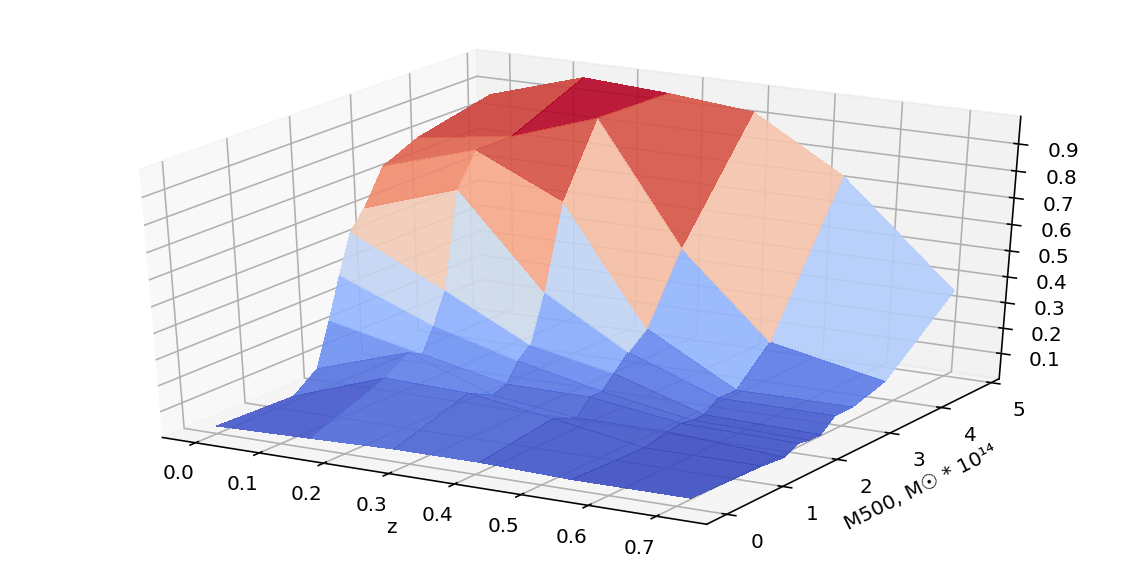

In [13]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 5))
X, Y = np.meshgrid(q_z[:-1], q_m[:-1])

Z = np.zeros_like(X)

ax.set_zticks(np.arange(0, 1.1, 0.1))
cols = list(recalls)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i,j] = recalls[cols[j]].iloc[i]
#X, Y = np.meshgrid(list(range(len(q_z) - 1)), list(range(len(q_m) - 1)))
        
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                       linewidth=0, antialiased=False, alpha=0.9)

# Customize the z axis.
#ax.set_zlim(0, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xlabel('z')
ax.set_ylabel('M500, M☉ * 10¹⁴')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()